In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, latent_dim=200):
        super(VAE, self).__init__()

        # Encoder: 4 Conv2d layers with stride=2, kernel=4, padding=1
        # Input: (3, 64, 64) -> (32, 32, 32) -> (64, 16, 16) -> (128, 8, 8) -> (256, 4, 4)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),    # 0
            nn.ReLU(),                                                # 1
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # 2
            nn.ReLU(),                                                # 3
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 4
            nn.ReLU(),                                                # 5
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 6
            nn.ReLU(),                                                # 7
        )

        # 256 * 4 * 4 = 4096
        self.fc_mu = nn.Linear(4096, latent_dim)
        self.fc_logvar = nn.Linear(4096, latent_dim)

        # Decoder input
        self.decoder_input = nn.Linear(latent_dim, 4096)

        # Decoder: 4 ConvTranspose2d layers
        # (256, 4, 4) -> (128, 8, 8) -> (64, 16, 16) -> (32, 32, 32) -> (3, 64, 64)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 0
            nn.ReLU(),                                                          # 1
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2
            nn.ReLU(),                                                          # 3
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 4
            nn.ReLU(),                                                          # 5
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),     # 6
            nn.Sigmoid(),                                                       # 7
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch, 4096)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), 256, 4, 4)  # Reshape to (batch, 256, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from torch.optim import AdamW
import random

# --- Simple GMM Implementation ---

class SimpleGMM:
    """Simple Gaussian Mixture Model using K-means initialization."""
    def __init__(self, n_components, n_features, n_iter=100):
        self.n_components = n_components
        self.n_features = n_features
        self.n_iter = n_iter
        self.mu = None  # [n_components, n_features]

    def fit(self, X):
        """Fit GMM using K-means."""
        device = X.device
        n_samples = X.shape[0]

        # Initialize centroids randomly
        indices = torch.randperm(n_samples)[:self.n_components]
        self.mu = X[indices].clone()

        # K-means iterations
        for _ in range(self.n_iter):
            # Assign samples to nearest centroid
            distances = torch.cdist(X, self.mu)
            assignments = torch.argmin(distances, dim=1)

            # Update centroids
            new_mu = torch.zeros_like(self.mu)
            for k in range(self.n_components):
                mask = assignments == k
                if mask.sum() > 0:
                    new_mu[k] = X[mask].mean(dim=0)
                else:
                    new_mu[k] = self.mu[k]
            self.mu = new_mu

        return self

    def predict(self, X):
        """Predict cluster assignments."""
        distances = torch.cdist(X, self.mu)
        return torch.argmin(distances, dim=1)


# --- DeepSigns Module ---

class DeepSignsModule(nn.Module):
    """Learnable GMM means that project to watermark space."""
    def __init__(self, gmm_mu):
        super().__init__()
        self.var_param = nn.Parameter(gmm_mu.clone(), requires_grad=True)

    def forward(self, matrix_a):
        matrix_g = torch.sigmoid(self.var_param @ matrix_a)
        return matrix_g


# --- Feature Hook ---

class FeatureHook:
    """Hook to capture intermediate activations."""
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module, input, output):
        self.features = output

    def close(self):
        self.hook.remove()


# --- Classe Principale DeepSigns DDPM ---

class DeepSignsVAE:
    def __init__(self, model, device="cuda"):
        self.device = device
        self.model = model

        # Configuration par defaut
        self.config = {
            "layer_name": "decoder.6",  # Couche cible
            "watermark_len":4,
            "n_components": 5,      # Nombre de clusters GMM
            "nb_wat_classes": 2,     # Nombre de classes porteuses
            "trigger_size": 256,     # Taille du trigger set
            "lr": 1e-4,
            "lr_ds": 1e-3,           # Learning rate for DeepSigns module
            "lambda_1": 0.1,         # GMM loss weight
            "lambda_2": 5.0,         # Watermark loss weight
            "epochs": 10,
            "beta_kl": 1.0,            # Poids du terme KL dans la perte VAE
        }

        self.saved_keys = {}

    def _get_layer(self, model, layer_name):
        """Navigate to a layer by its path."""
        layer = model
        for part in layer_name.split('.'):
            if part.isdigit():
                layer = layer[int(part)]
            else:
                layer = getattr(layer, part)
        return layer

    def _extract_activations(self, model, dataloader, max_samples=1000):
        """
        Extract activations from the target layer for GMM fitting.
        """
        target_layer = self._get_layer(model, self.config["layer_name"])
        hook = FeatureHook(target_layer)

        activations = []
        inputs_list = []

        model.eval()
        n_samples = 0

        with torch.no_grad():
            for clean_images, _ in dataloader:
                if n_samples >= max_samples:
                    break

                clean_images = clean_images.to(self.device)


                _ = model(clean_images)

                # Global average pooling and flatten
                act = hook.features
                if len(act.shape) == 4:
                    act = act.mean(dim=(2, 3))  # [B, C]
                activations.append(act.cpu())
                inputs_list.append(clean_images.detach().cpu())

            n_samples += clean_images.size(0)



        hook.close()

        activations = torch.cat(activations, dim=0)[:max_samples]
        inputs_list = torch.cat(inputs_list, dim=0)[:max_samples]

        return activations.to(self.device), inputs_list.to(self.device)

    def _mu_loss(self, act, mu, mu_bar, watermarked_classes, y_key):
        """
        Compute GMM loss:
        - Minimize distance between carrier class means and statistical means
        - Maximize distance between carrier and non-carrier means
        """
        # Compute statistical means for each watermarked class
        stat_means = torch.stack([
            act[y_key == t].mean(dim=0) if (y_key == t).sum() > 0 else mu[i]
            for i, t in enumerate(watermarked_classes)
        ])

        # Loss to approach GMM means to statistical means
        gmm_loss = F.mse_loss(stat_means, mu, reduction='sum')

        # Loss to separate carrier and non-carrier means
        if len(mu_bar) > 0:
            sep_loss = F.mse_loss(
                mu.unsqueeze(1).expand(-1, len(mu_bar), -1),
                mu_bar.unsqueeze(0).expand(len(mu), -1, -1),
                reduction='mean'
            )
        else:
            sep_loss = torch.tensor(0.0, device=self.device)

        return gmm_loss, sep_loss

    def embed(self, dataloader):
        """
        Incorpore la marque DeepSigns pendant le finetuning.
        Utilise GMM pour identifier les classes porteuses.
        """
        print(f"--- Demarrage Embedding DeepSigns in VAE({self.config['layer_name']}) ---")

        watermarked_model= self.model.to(self.device)

        # 1. Extract activations for GMM
        print("Extracting activations for GMM...")
        activations, trigger_inputs= self._extract_activations(
            watermarked_model, dataloader, max_samples=self.config["trigger_size"]
        )
        n_features = activations.shape[1]
        print(f"Activation shape: {activations.shape}")

        # 2. Fit GMM
        print("Fitting GMM...")
        gmm = SimpleGMM(self.config["n_components"], n_features)
        gmm.fit(activations)

        # 3. Select watermarked classes (carrier classes)
        y_gmm = gmm.predict(activations)
        unique_classes = torch.unique(y_gmm).tolist()
        n_wat = min(self.config["nb_wat_classes"], len(unique_classes))
        watermarked_classes = torch.tensor(random.sample(unique_classes, n_wat), device=self.device)
        print(f"Watermarked classes: {watermarked_classes.tolist()}")

        # 4. Create trigger set (samples from watermarked classes)
        trigger_mask = torch.isin(y_gmm, watermarked_classes)
        x_key =trigger_inputs[trigger_mask].to(self.device)

        y_key = y_gmm[trigger_mask].to(self.device)
        print(f"Trigger set size: {len(x_key)}")

        if len(x_key) == 0:
            print("Warning: Empty trigger set, using all samples")
            x_key = trigger_inputs

            y_key = y_gmm.to(self.device)

        # 5. Generate watermark and matrix_a
        watermark = torch.randint(0, 2, (n_wat, self.config["watermark_len"])).float().to(self.device)
        matrix_a = torch.randn(n_features, self.config["watermark_len"]).to(self.device)
        print(f"Watermark shape: {watermark.shape}")

        # 6. Initialize DeepSigns module with GMM means of carrier classes
        mu_carriers = gmm.mu[watermarked_classes.cpu()].to(self.device)
        deepsigns_module = DeepSignsModule(mu_carriers).to(self.device)

        # Non-carrier means (frozen)
        non_carrier_idx = [i for i in range(self.config["n_components"]) if i not in watermarked_classes.tolist()]
        mu_bar = gmm.mu[non_carrier_idx].to(self.device).detach()

        # 7. Optimizer
        watermarked_model.train()
        optimizer = torch.optim.AdamW([
            {'params': watermarked_model.parameters(), 'lr': self.config["lr"]},
            {'params': deepsigns_module.parameters(), 'lr': self.config["lr_ds"]}
        ])

        mse_loss = nn.MSELoss()
        bce_loss = nn.BCELoss()

        # Hook for activation extraction during training
        target_layer = self._get_layer(watermarked_model, self.config["layer_name"])

        # 8. Training loop
        for epoch in range(self.config["epochs"]):
            pbar = tqdm(dataloader)
            for clean_images, _ in pbar:
                clean_images = clean_images.to(self.device)


                optimizer.zero_grad()

                recon, mu, logvar = watermarked_model(clean_images)
                # Reconstruction loss
                l_recon = F.mse_loss(recon, clean_images)

                # KL divergence
                l_kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

                # VAE total task loss
                l_main = l_recon + self.config["beta_kl"] * l_kl

                # B. Extract activations from trigger set
                hook = FeatureHook(target_layer)
                _ = watermarked_model(x_key)
                act = hook.features
                if len(act.shape) == 4:
                    act = act.mean(dim=(2, 3))
                hook.close()

                # C. GMM Loss
                mu_dp = deepsigns_module.var_param
                gmm_loss, sep_loss = self._mu_loss(act, mu_dp, mu_bar, watermarked_classes, y_key)
                l_mu = gmm_loss - sep_loss

                # D. Watermark Loss
                matrix_g = deepsigns_module(matrix_a)
                l_wat = bce_loss(matrix_g, watermark)

                mu_stat = torch.stack([act[y_key == t].mean(dim=0) for t in watermarked_classes])
                l_align = F.mse_loss(mu_stat, deepsigns_module.var_param)

                # Total loss
                # l_total = l_main + self.config["lambda_1"] * l_mu + self.config["lambda_2"] * l_wat
                l_total = l_main + gmm_loss + l_align - self.config["lambda_1"] * sep_loss + self.config["lambda_2"] * l_wat

                l_total.backward()
                optimizer.step()

                # Metrics
                ber = self._compute_ber(matrix_g, watermark)
                pbar.set_description(
                    f"Epoch {epoch+1} | L_Main: {l_main:.3f} | L_Mu: {l_mu:.3f} | L_Wat: {l_wat:.3f} | BER: {ber:.2f}"
                )

            #     if ber == 0.0 and l_wat.item() < 0.1:
            #         print("Convergence atteinte !")
            #         break
            # if ber == 0.0:
            #     break

        # Save keys
        self.saved_keys = {
            "watermark": watermark,
            "matrix_a": matrix_a,
            "watermarked_classes": watermarked_classes,
            "watermarked_model": watermarked_model,
            "deepsigns_module": deepsigns_module,
            "x_key": x_key,
            "y_key": y_key,
        }
        torch.save(self.saved_keys, "Deepsign_VAE_model_checkpoint.pt")
        return watermarked_model

    def extract(self, model=None):
        """
        Extrait la marque d'un modele suspect en utilisant les moyennes statistiques.
        """
        if model is None:
            model = self.saved_keys["watermarked_model"]

        watermark = self.saved_keys["watermark"]
        matrix_a = self.saved_keys["matrix_a"]
        watermarked_classes = self.saved_keys["watermarked_classes"]
        x_key = self.saved_keys["x_key"]

        y_key = self.saved_keys["y_key"]

        # Extract activations
        target_layer = self._get_layer(model, self.config["layer_name"])
        hook = FeatureHook(target_layer)

        model.eval()
        with torch.no_grad():
            _ = model(x_key)
            act = hook.features
            if len(act.shape) == 4:
                act = act.mean(dim=(2, 3))
        hook.close()

        # Compute statistical means for each watermarked class
        mu_ext = torch.stack([
            act[y_key == t].mean(dim=0) if (y_key == t).sum() > 0 else torch.zeros(act.shape[1], device=self.device)
            for t in watermarked_classes
        ])

        # Project through matrix_a
        g_ext = torch.sigmoid(mu_ext @ matrix_a)
        ber = self._compute_ber(g_ext, watermark)

        print(f"BER Extrait : {ber:.2f}")
        return ber, g_ext

    @staticmethod
    def _compute_ber(pred, target):
        return ((pred > 0.5).float() != target).float().mean().item()


In [6]:
# --- EXEMPLE D'UTILISATION ---

# 1. Data Loader
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
from torchvision import transforms


import torch
import gc

gc.collect()
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load from Hugging Face (no Google Drive issues)
print("Loading dataset...")
hf_dataset = load_dataset("nielsr/CelebA-faces", split="train")

class CelebAWrapper(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if self.transform:
            image = self.transform(image)
        return image, 0

dataset = CelebAWrapper(hf_dataset, transform)
print("Dataset loaded!")

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
print("loader loaded!")






Loading dataset...
Dataset loaded!
loader loaded!


In [7]:
# --- EXEMPLE D'EXECUTION ---
#load model
latent_dim = 200

# Initialize the model
model = VAE(latent_dim=latent_dim)

# Load the trained weights
model_path = "./vae_celeba_latent_200_epochs_10_batch_64_subset_80000.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)

# 2. Embedding DeepSigns
deepsigns_defense = DeepSignsVAE(model, device=device)
watermarked_model = deepsigns_defense.embed(dataloader)

--- Demarrage Embedding DeepSigns in VAE(decoder.6) ---
Extracting activations for GMM...
Activation shape: torch.Size([256, 3])
Fitting GMM...
Watermarked classes: [2, 3]
Trigger set size: 134
Watermark shape: torch.Size([2, 4])


Epoch 1 | L_Main: 0.408 | L_Mu: -4.056 | L_Wat: 0.125 | BER: 0.00: 100%|██████████| 3166/3166 [01:32<00:00, 34.13it/s]
Epoch 2 | L_Main: 0.371 | L_Mu: -12.280 | L_Wat: 0.041 | BER: 0.00: 100%|██████████| 3166/3166 [01:33<00:00, 33.82it/s]
Epoch 3 | L_Main: 0.369 | L_Mu: -28.227 | L_Wat: 0.013 | BER: 0.00: 100%|██████████| 3166/3166 [01:41<00:00, 31.14it/s]
Epoch 4 | L_Main: 0.365 | L_Mu: -55.370 | L_Wat: 0.004 | BER: 0.00: 100%|██████████| 3166/3166 [01:46<00:00, 29.65it/s]
Epoch 5 | L_Main: 0.410 | L_Mu: -95.321 | L_Wat: 0.001 | BER: 0.00: 100%|██████████| 3166/3166 [01:43<00:00, 30.62it/s]
Epoch 6 | L_Main: 0.353 | L_Mu: -148.665 | L_Wat: 0.001 | BER: 0.00: 100%|██████████| 3166/3166 [01:46<00:00, 29.75it/s]
Epoch 7 | L_Main: 0.402 | L_Mu: -214.968 | L_Wat: 0.000 | BER: 0.00: 100%|██████████| 3166/3166 [01:47<00:00, 29.39it/s]
Epoch 8 | L_Main: 0.362 | L_Mu: -293.007 | L_Wat: 0.000 | BER: 0.00: 100%|██████████| 3166/3166 [01:45<00:00, 30.10it/s]
Epoch 9 | L_Main: 0.361 | L_Mu: -381.8

In [8]:
# 3. Extraction (Test immediat)
ber, _ = deepsigns_defense.extract(watermarked_model)
print(f"\nResultat final - BER: {ber:.2f}")

BER Extrait : 0.00

Resultat final - BER: 0.00


In [9]:
# --- Fonction de Distillation (Attaque) ---
import torch
import torch.nn.functional as F
from diffusers import UNet2DModel, DDPMScheduler
from torch.optim import AdamW
from tqdm import tqdm
import torch.optim as optim
def run_distillation_attack_deepsigns(ds_obj, dataloader, epochs=5, lr=1e-4):
    """
    Tente de transferer la fonctionnalite du modele DeepSigns vers un modele vierge.
    Verifie si la marque (basee sur les moyennes GMM) survit.
    """
    device = ds_obj.device

    checkpoint = torch.load("Deepsign_VAE_model_checkpoint.pt", weights_only=False)

    # 1. Teacher (Gele)
    teacher = checkpoint["watermarked_model"]
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad = False

    # 2. Student (Vierge - Meme architecture)
    print("\n--- Initialisation du Student ---")

    student=VAE(latent_dim=latent_dim)
    student.load_state_dict(torch.load(model_path))
    student.to(device)
    student.train()

    teacher_ber, _ = ds_obj.extract(teacher)
    student_ber, _ = ds_obj.extract(student)
    print(f"[Check] BER Teacher: {teacher_ber:.2f}")
    print(f"[Check] BER Student (Avant): {student_ber:.2f}")

    optimizer = AdamW(student.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5], gamma=0.1)
    history = {"loss": [], "ber": []}

    print(f"\n--- Distillation DeepSigns ({epochs} epochs) ---")
    a=0
    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
        running_loss = 0.0

        for clean_images, _ in pbar:
            clean_images = clean_images.to(device)


            with torch.no_grad():
                target_pred,_,_ = teacher(clean_images)

            student_pred,_,_ = student(clean_images)

            loss1 = F.mse_loss(student_pred, clean_images)

            loss2 = F.mse_loss(student_pred, target_pred)
            loss = 0.1* loss1 + 0.9 * loss2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(Loss=loss.item())

        current_ber, g_ext = ds_obj.extract(student)
        history["ber"].append(current_ber)
        history["loss"].append(running_loss / len(dataloader))

        err_wat = nn.BCELoss()(g_ext, ds_obj.saved_keys["watermark"]).item()
        print(f"Fin Epoch {epoch+1} | Loss: {history['loss'][-1]:.4f} | BER Student: {current_ber:.2f} | err_wat: {err_wat:.4f}")
        if current_ber==0.0 and a>=1:
            print("✅ Marque récupérée avec succès par distillation !")
            break
        elif current_ber==0.0 and a<1 :
            a+=1
        else:
            a=0

    return student, history


In [10]:
# 4. Attaque par Distillation
student_res, stats = run_distillation_attack_deepsigns(deepsigns_defense, dataloader, epochs=1000)


--- Initialisation du Student ---
BER Extrait : 0.00
BER Extrait : 0.12
[Check] BER Teacher: 0.00
[Check] BER Student (Avant): 0.12

--- Distillation DeepSigns (1000 epochs) ---


Epoch 1: 100%|██████████| 3166/3166 [01:25<00:00, 37.13it/s, Loss=0.0396]


BER Extrait : 0.62
Fin Epoch 1 | Loss: 0.0424 | BER Student: 0.62 | err_wat: 2.1904


Epoch 2: 100%|██████████| 3166/3166 [01:25<00:00, 37.11it/s, Loss=0.042] 


BER Extrait : 0.62
Fin Epoch 2 | Loss: 0.0404 | BER Student: 0.62 | err_wat: 2.2328


Epoch 3: 100%|██████████| 3166/3166 [01:27<00:00, 36.19it/s, Loss=0.0427]


BER Extrait : 0.62
Fin Epoch 3 | Loss: 0.0401 | BER Student: 0.62 | err_wat: 2.3458


Epoch 4: 100%|██████████| 3166/3166 [01:26<00:00, 36.72it/s, Loss=0.0359]


BER Extrait : 0.62
Fin Epoch 4 | Loss: 0.0399 | BER Student: 0.62 | err_wat: 2.1861


Epoch 5: 100%|██████████| 3166/3166 [01:27<00:00, 36.22it/s, Loss=0.0414]


BER Extrait : 0.62
Fin Epoch 5 | Loss: 0.0398 | BER Student: 0.62 | err_wat: 2.1213


Epoch 6: 100%|██████████| 3166/3166 [01:26<00:00, 36.66it/s, Loss=0.0406]


BER Extrait : 0.50
Fin Epoch 6 | Loss: 0.0396 | BER Student: 0.50 | err_wat: 1.7818


Epoch 7: 100%|██████████| 3166/3166 [01:25<00:00, 37.04it/s, Loss=0.0429]


BER Extrait : 0.38
Fin Epoch 7 | Loss: 0.0396 | BER Student: 0.38 | err_wat: 1.4873


Epoch 8: 100%|██████████| 3166/3166 [01:25<00:00, 36.89it/s, Loss=0.0441]


BER Extrait : 0.38
Fin Epoch 8 | Loss: 0.0395 | BER Student: 0.38 | err_wat: 1.1263


Epoch 9: 100%|██████████| 3166/3166 [01:25<00:00, 36.93it/s, Loss=0.0368]


BER Extrait : 0.25
Fin Epoch 9 | Loss: 0.0395 | BER Student: 0.25 | err_wat: 1.1604


Epoch 10: 100%|██████████| 3166/3166 [01:25<00:00, 36.94it/s, Loss=0.0385]


BER Extrait : 0.25
Fin Epoch 10 | Loss: 0.0394 | BER Student: 0.25 | err_wat: 0.9341


Epoch 11: 100%|██████████| 3166/3166 [01:27<00:00, 36.23it/s, Loss=0.0375]


BER Extrait : 0.25
Fin Epoch 11 | Loss: 0.0393 | BER Student: 0.25 | err_wat: 0.5753


Epoch 12: 100%|██████████| 3166/3166 [01:27<00:00, 36.36it/s, Loss=0.0348]


BER Extrait : 0.25
Fin Epoch 12 | Loss: 0.0393 | BER Student: 0.25 | err_wat: 0.5005


Epoch 13: 100%|██████████| 3166/3166 [01:27<00:00, 36.01it/s, Loss=0.0381]


BER Extrait : 0.25
Fin Epoch 13 | Loss: 0.0393 | BER Student: 0.25 | err_wat: 0.5136


Epoch 14: 100%|██████████| 3166/3166 [01:27<00:00, 36.25it/s, Loss=0.0382]


BER Extrait : 0.25
Fin Epoch 14 | Loss: 0.0392 | BER Student: 0.25 | err_wat: 0.7479


Epoch 15: 100%|██████████| 3166/3166 [01:27<00:00, 36.35it/s, Loss=0.0405]


BER Extrait : 0.12
Fin Epoch 15 | Loss: 0.0391 | BER Student: 0.12 | err_wat: 0.3012


Epoch 16: 100%|██████████| 3166/3166 [01:27<00:00, 36.31it/s, Loss=0.0372]


BER Extrait : 0.25
Fin Epoch 16 | Loss: 0.0392 | BER Student: 0.25 | err_wat: 0.3379


Epoch 17: 100%|██████████| 3166/3166 [01:26<00:00, 36.70it/s, Loss=0.0423]


BER Extrait : 0.12
Fin Epoch 17 | Loss: 0.0391 | BER Student: 0.12 | err_wat: 0.2439


Epoch 18: 100%|██████████| 3166/3166 [01:25<00:00, 36.91it/s, Loss=0.0397]


BER Extrait : 0.12
Fin Epoch 18 | Loss: 0.0391 | BER Student: 0.12 | err_wat: 0.3170


Epoch 19: 100%|██████████| 3166/3166 [01:26<00:00, 36.69it/s, Loss=0.0413]


BER Extrait : 0.12
Fin Epoch 19 | Loss: 0.0391 | BER Student: 0.12 | err_wat: 0.2300


Epoch 20: 100%|██████████| 3166/3166 [01:27<00:00, 36.07it/s, Loss=0.0313]


BER Extrait : 0.12
Fin Epoch 20 | Loss: 0.0391 | BER Student: 0.12 | err_wat: 0.2388


Epoch 21: 100%|██████████| 3166/3166 [01:25<00:00, 36.99it/s, Loss=0.0403]


BER Extrait : 0.00
Fin Epoch 21 | Loss: 0.0391 | BER Student: 0.00 | err_wat: 0.2074


Epoch 22: 100%|██████████| 3166/3166 [01:25<00:00, 37.03it/s, Loss=0.0387]


BER Extrait : 0.12
Fin Epoch 22 | Loss: 0.0391 | BER Student: 0.12 | err_wat: 0.2571


Epoch 23: 100%|██████████| 3166/3166 [01:25<00:00, 37.15it/s, Loss=0.0391]


BER Extrait : 0.00
Fin Epoch 23 | Loss: 0.0390 | BER Student: 0.00 | err_wat: 0.2028


Epoch 24: 100%|██████████| 3166/3166 [01:26<00:00, 36.68it/s, Loss=0.0394]

BER Extrait : 0.00
Fin Epoch 24 | Loss: 0.0390 | BER Student: 0.00 | err_wat: 0.2267
✅ Marque récupérée avec succès par distillation !


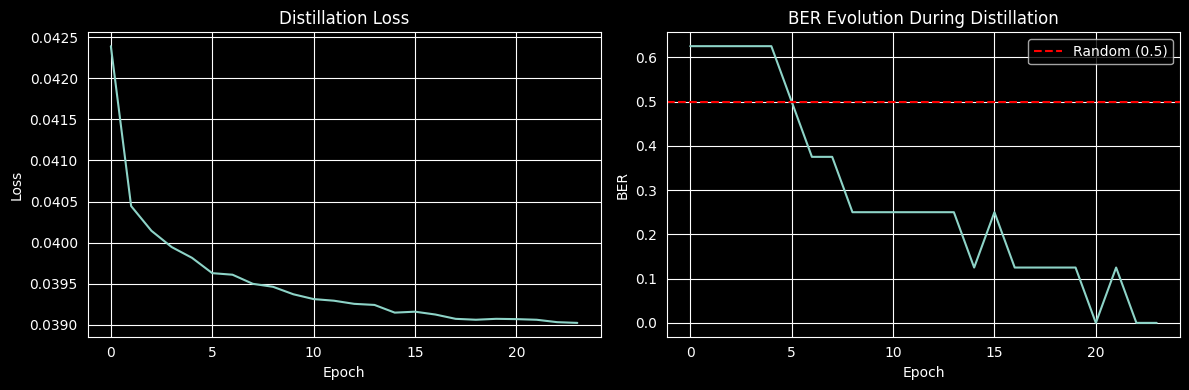

In [11]:
# 5. Visualisation des resultats
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(stats["loss"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Distillation Loss")

ax2.plot(stats["ber"])
ax2.axhline(y=0.5, color='r', linestyle='--', label='Random (0.5)')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("BER")
ax2.set_title("BER Evolution During Distillation")
ax2.legend()

plt.tight_layout()
plt.show()